In [1]:
# Imports
import numpy as np
from astropy.io import fits
import astropy.units as u
from pathlib import Path
from matplotlib import pyplot as plt
from astropy.io import fits
from matplotlib.pyplot import *
from dust_extinction.averages import GCC09_MWAvg as dext
import lineid_plot
def plot_prettier(dpi=300, fontsize=9, figsize = (11,8.5)):
    # import pyplot and set some parameters to make plots prettier
    import matplotlib.pyplot as plt
    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines
    plt.rc('figure', figsize=figsize,facecolor='white')
    
    return
plot_prettier(150, fontsize=18)

np.set_printoptions(suppress=True)
import scipy
from matplotlib import pyplot
import scipy.ndimage
from mangadap.util.bitmask import BitMask
bitmask_path =  str(Path().absolute())+r"\eBOSSDAP\sdssMaskbits.par"
targ1bm = BitMask.from_par_file(bitmask_path, 'SPPIXMASK')



In [2]:
def autoscale(ax=None, axis='y', margin=0.2,std=1000,stdmult=5,avg=0,fit_type = 2):
    '''Autoscales the x or y axis of a given matplotlib ax object
    to fit the margins set by manual limits of the other axis,
    with margins in a fraction of the width of the plot
    Defaults to the current axes object if not specified.


    This is in Beta, and should be used once to find a rough estimate of the limits before setting custom limits.
    '''
    import matplotlib.pyplot as plt
    if ax is None:
        ax = plt.gca()
    newlow, newhigh = np.inf, -np.inf
    
    for artist in ax.collections + ax.lines:
        x,y = get_xy(artist)
        if axis == 'y':
            setlim = ax.set_ylim
            lim = ax.get_xlim()
            fixed, dependent = x, y
        else:
            setlim = ax.set_xlim
            lim = ax.get_ylim()
            fixed, dependent = y, x

        low, high, mean,nstd = calculate_new_limit(fixed, dependent, lim,stdmult)
        newlow = low if low < newlow else newlow
        newhigh = high if high > newhigh else newhigh

    margin = margin*(newhigh - newlow)
    
    
    if fit_type == 0: 
        #old normal lims
        setlim(newlow-margin, newhigh+margin)
    
    elif fit_type==1:
        #new lims with the found std minimized 
        if (newhigh+margin < (mean + nstd*stdmult)):
            if newlow-margin > (mean - nstd*stdmult):
                setlim(newlow-margin, newhigh+margin) 
            else:
                setlim((mean - nstd*stdmult), newhigh+margin)
        else:
            if newlow-margin > (mean - nstd*stdmult):
                setlim(newlow-margin, (mean + nstd*stdmult)) 
            else:
                setlim((mean - nstd*stdmult), (mean + nstd*stdmult)) 
    elif fit_type==2:
        stdmult = 5
        #new lims with 5 stds as given
        if (newhigh+margin < (avg + std*stdmult)):
            if newlow-margin > (avg - std*stdmult):
                setlim(newlow-margin, newhigh+margin) 
            else:
                setlim((avg - std*stdmult), newhigh+margin)
        else:
            if newlow-margin > (avg - std*stdmult):
                setlim(newlow-margin, (avg + std*stdmult)) 
            else:
                setlim((avg - std*stdmult), (avg + std*stdmult)) 
    elif fit_type==3:
        # new std averaged lines with found stds
        #stdmult = 10
        setlim((avg - nstd*stdmult), (avg + nstd*stdmult)) 
    elif fit_type==4:
        stdmult = 3
        #new lims with 5 stds 
        if (newhigh+margin < (avg + std*stdmult)):
            if newlow-margin > (avg - std*stdmult):
                setlim(newlow-margin, newhigh+margin) 
            else:
                setlim((avg - std*stdmult), newhigh+margin)
        else:
            if newlow-margin > (avg - std*stdmult):
                setlim(newlow-margin, (avg + std*stdmult)) 
            else:
                setlim((avg - std*stdmult), (avg + std*stdmult)) 
        
def calculate_new_limit(fixed, dependent, limit,numstd):
    '''Calculates the min/max of the dependent axis given 
    a fixed axis with limits
    '''
    if len(fixed) > 2:
        mask = (fixed>limit[0]) & (fixed < limit[1])
        window = dependent[mask]
        std = window.std()
        low = window.min() #- (std*numstd)
        high = window.max() #- (std*numstd)
        mean = np.median(window) # window.mean()

    else:
        low = dependent[0]
        high = dependent[-1]
        mean = 0
        std = np.inf
        if low == 0.0 and high == 1.0:
            # This is a axhline in the autoscale direction
            low = np.inf
            high = -np.inf
    return low, high, mean,std 

def get_xy(artist):
    '''Gets the xy coordinates of a given artist
    '''
    if "Collection" in str(artist):
        x, y = artist.get_offsets().T
    elif "Line" in str(artist):
        x, y = artist.get_xdata(), artist.get_ydata()
    else:
        raise ValueError("This type of object isn't implemented yet")
    return x, y

In [3]:
# Define your variables such as what spectra you want to plot and what all the colors should be. eBOSS-DAP attempts to use color-blind friendly plots.
tag = '3650-55244-0001'
bin = 'bin_001'
#whether custom or autoscaled limits are used. We recommend starting with autoscaled to get an idea of the scale for the spectra before switching to custom scaling.
custom_limits = False

data_c = 'C0'
model_c = 'C1'
mask_c = "xkcd:dark red"
data_mask_c = "xkcd:dark blue"
elcont_c = "xkcd:dark yellow"
err_c = "gray"
resid_c = 'k'
zeroline_c="xkcd:light grey"


show_masked = True #Whether or not the Locations where inverse variance is less than or equal to zero or is undefined are shown

show_data_mask = True #Whether or not the AND_MASK of teh data is shown


In [4]:
#-------------------------------------------------------------------------------------------------------------------
#set x-axis limits for all subplots
cont_c_xlim = [3675,4100]
cont_d_xlim = [4761,4961]
cont_e_xlim = [5800,5950]

eml_b_xlim = [2700,3500]
eml_c_xlim = [3701,3999]
eml_d_xlim = [4263,4463]
eml_e_xlim = [4801,5049]
eml_f_xlim = [6501,6628]
eml_g_xlim = [6673,6775]
#-------------------------------------------------------------------------------------------------------------------
if custom_limits:
    #set custom x-axis and y-axis limits for all subplots
    
    cont_c_xlim = [3675,4100]
    cont_d_xlim = [4761,4961]
    cont_e_xlim = [5800,5950]

    cont_c_ylim = [0.5,2.5]
    cont_d_ylim = [0.5,2.0]  
    cont_e_ylim = [0,3.5]
    
    eml_b_xlim = [2700,3500]
    eml_c_xlim = [3701,3999]
    eml_d_xlim = [4263,4463]
    eml_e_xlim = [4801,5049]
    eml_f_xlim = [6501,6628]
    eml_g_xlim = [6673,6775]
    
    eml_a_ylim = [0.0,20.0]
    eml_b_ylim = [-0.5,5]
    eml_c_ylim = [-0.5,35.0]  
    eml_d_ylim = [-0.5,5.5]  
    eml_e_ylim = [-0.5,75.5]  
    eml_f_ylim = [-0.5,25.0]  
    eml_g_ylim = [-0.5,17.5]  


#read in data
fit = fits.open(str(Path().absolute())+r'\\fits\\'+tag+'_fit.fits')
data = fits.open(str(Path().absolute())+'\\'+bin+'\\'+tag.split('-')[0]+'\\spec-'+tag+'.fits')

In [5]:
fit[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                 4623                                                  
EXTEND  =                    T                                                  
NPIXFIT =                 4518                                                  
RCHI2   =                1.058                                                  
REDSHIFT=            0.5735726                                                  
HIERARCH guess_dispersion = 100.0                                               
RA      =    41.22182556597496                                                  
DEC     =  -0.8189531316914165                                                  
HIERARCH E(B-V) =   0.0254465521499514                                          
HIERARCH sc_velocity = 17193

In [6]:
#Reads in the previously measured E(B-V) based on Milky-Way dust extinction. 
ebv = fit[0].header['E(B-V)']
ext = dext()

#Reads in the spectra and performs dust correction, creating loglam, flux, and ivars
loglam = data[1].data['loglam']
wave = 10 ** loglam
lamu = wave*u.AA
corr = ext.extinguish(lamu,Ebv=ebv)
flux = data[1].data['flux']  / corr
ivar = data[1].data['ivar'] * corr**2

#creates error
err = np.ma.power(ivar, -0.5)

#creates mask
model_mask = fit[2].data
and_mask = targ1bm.flagged(targ1bm.turn_off(data[1].data['and_mask'].astype(int), 'BRIGHTSKY'))#data[1].data['and_mask']
var_inf = np.logical_not(np.isfinite(flux)) | np.logical_not(np.isfinite(ivar))
var_neg = np.where(ivar <= 0,True,False)
data_mask = and_mask | var_inf | var_neg
data_flux =  flux 
errors = np.ma.masked_array(err,mask = model_mask)

#finds redshift and creates rest wavelength array
z = fit[0].header['redshift']
restwave = wave / (1+z)

# read in the fit make smoothed versions
model_flux =  fit[0].data
data_to_smooth = np.where(model_mask==1, model_flux, data_flux)
smoothed_data = scipy.ndimage.median_filter(data_to_smooth, size=(5)) 
smoothed_model = scipy.ndimage.median_filter(model_flux, size=(5))

# read in just the emission line flux over continuum and create a continuum model
eml_flux = fit[1].data
el_continuum = fit[0].data - fit[1].data
smoothed_el_continuum =  scipy.ndimage.median_filter(el_continuum, size=(5))

# create a continuum subtracted spectrum fro the initial data
data_el = data_flux - el_continuum 
resid = flux - model_flux 
data_std = np.std(resid)
data_avg = np.mean(data_flux)
fstd = 1
#-------------------------------------------------------------------------------------------------------------------

# Create the mask lines to plot with approximate pixel widths


mask_lines = restwave[model_mask==1]
mask_line_left = restwave[np.where(model_mask)[0] - 1]


right_arr = np.where(model_mask)[0] + 1
if right_arr[-1] == len(restwave):
    right_arr[-1] = 0
mask_line_right = restwave[right_arr]
mask_lws_init = mask_line_right - mask_line_left
mask_lws_init[mask_lws_init < 0] = 1

scaler = (restwave[-1] - restwave[0]) 

mask_lw_cont_a = (scaler / (restwave[-1] - restwave[0])) * 0.1 * mask_lws_init
mask_lw_cont_c = (scaler / (cont_c_xlim[1] - cont_c_xlim[0]))/3 * 0.1 * mask_lws_init
mask_lw_cont_d = (scaler / (cont_d_xlim[1] - cont_d_xlim[0]))/3 * 0.1 * mask_lws_init
mask_lw_cont_e = (scaler / (cont_e_xlim[1] - cont_e_xlim[0]))/3 * 0.1 * mask_lws_init

mask_lw_eml_a = (scaler / (restwave[-1] - restwave[0])) * 0.1 * mask_lws_init
mask_lw_eml_b = (scaler / (eml_b_xlim[1] - eml_b_xlim[0]))/3 * 0.1 * mask_lws_init
mask_lw_eml_c = (scaler / (eml_c_xlim[1] - eml_c_xlim[0]))/3 * 0.1 * mask_lws_init
mask_lw_eml_d = (scaler / (eml_d_xlim[1] - eml_d_xlim[0]))/3 * 0.1 * mask_lws_init
mask_lw_eml_e = (scaler / (eml_e_xlim[1] - eml_e_xlim[0]))/3 * 0.1 * mask_lws_init
mask_lw_eml_f = (scaler / (eml_f_xlim[1] - eml_f_xlim[0]))/3 * 0.1 * mask_lws_init
mask_lw_eml_g = (scaler / (eml_g_xlim[1] - eml_g_xlim[0]))/3 * 0.1 * mask_lws_init



data_mask_lines = restwave[data_mask!=0]
data_mask_line_left = restwave[np.where(data_mask)[0] - 1]

if len(data_mask_lines > 0): 
    data_right_arr = np.where(data_mask)[0] + 1
    if data_right_arr[-1] == len(restwave):
        data_right_arr[-1] = 0
    data_mask_line_right = restwave[data_right_arr]
    data_mask_lws_init = data_mask_line_right - data_mask_line_left
    data_mask_lws_init[data_mask_lws_init < 0] = 1
    
    scaler = (restwave[-1] - restwave[0]) 
    
    data_mask_lw_cont_a = (scaler / (restwave[-1] - restwave[0])) * 0.1 * data_mask_lws_init
    data_mask_lw_cont_c = (scaler / (cont_c_xlim[1] - cont_c_xlim[0]))/3 * 0.1 * data_mask_lws_init
    data_mask_lw_cont_d = (scaler / (cont_d_xlim[1] - cont_d_xlim[0]))/3 * 0.1 * data_mask_lws_init
    data_mask_lw_cont_e = (scaler / (cont_e_xlim[1] - cont_e_xlim[0]))/3 * 0.1 * data_mask_lws_init
    
    data_mask_lw_eml_a = (scaler / (restwave[-1] - restwave[0])) * 0.1 * data_mask_lws_init
    data_mask_lw_eml_b = (scaler / (eml_b_xlim[1] - eml_b_xlim[0]))/3 * 0.1 * data_mask_lws_init
    data_mask_lw_eml_c = (scaler / (eml_c_xlim[1] - eml_c_xlim[0]))/3 * 0.1 * data_mask_lws_init
    data_mask_lw_eml_d = (scaler / (eml_d_xlim[1] - eml_d_xlim[0]))/3 * 0.1 * data_mask_lws_init
    data_mask_lw_eml_e = (scaler / (eml_e_xlim[1] - eml_e_xlim[0]))/3 * 0.1 * data_mask_lws_init
    data_mask_lw_eml_f = (scaler / (eml_f_xlim[1] - eml_f_xlim[0]))/3 * 0.1 * data_mask_lws_init
    data_mask_lw_eml_g = (scaler / (eml_g_xlim[1] - eml_g_xlim[0]))/3 * 0.1 * data_mask_lws_init
else:
    data_right_arr = 0

    data_mask_line_right =0
    data_mask_lws_init =0
    
    data_mask_lw_cont_a = 0
    data_mask_lw_cont_c = 0
    data_mask_lw_cont_d = 0
    data_mask_lw_cont_e = 0
    
    data_mask_lw_eml_a = 0
    data_mask_lw_eml_b = 0
    data_mask_lw_eml_c = 0
    data_mask_lw_eml_d = 0
    data_mask_lw_eml_e = 0
    data_mask_lw_eml_f = 0
    data_mask_lw_eml_g = 0

C:\Users\owenm\AppData\Local\Temp\ipykernel_22676\256222807.py:8: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  subfigs[0].subplots_adjust(hspace=0.15,bottom = 0.1)


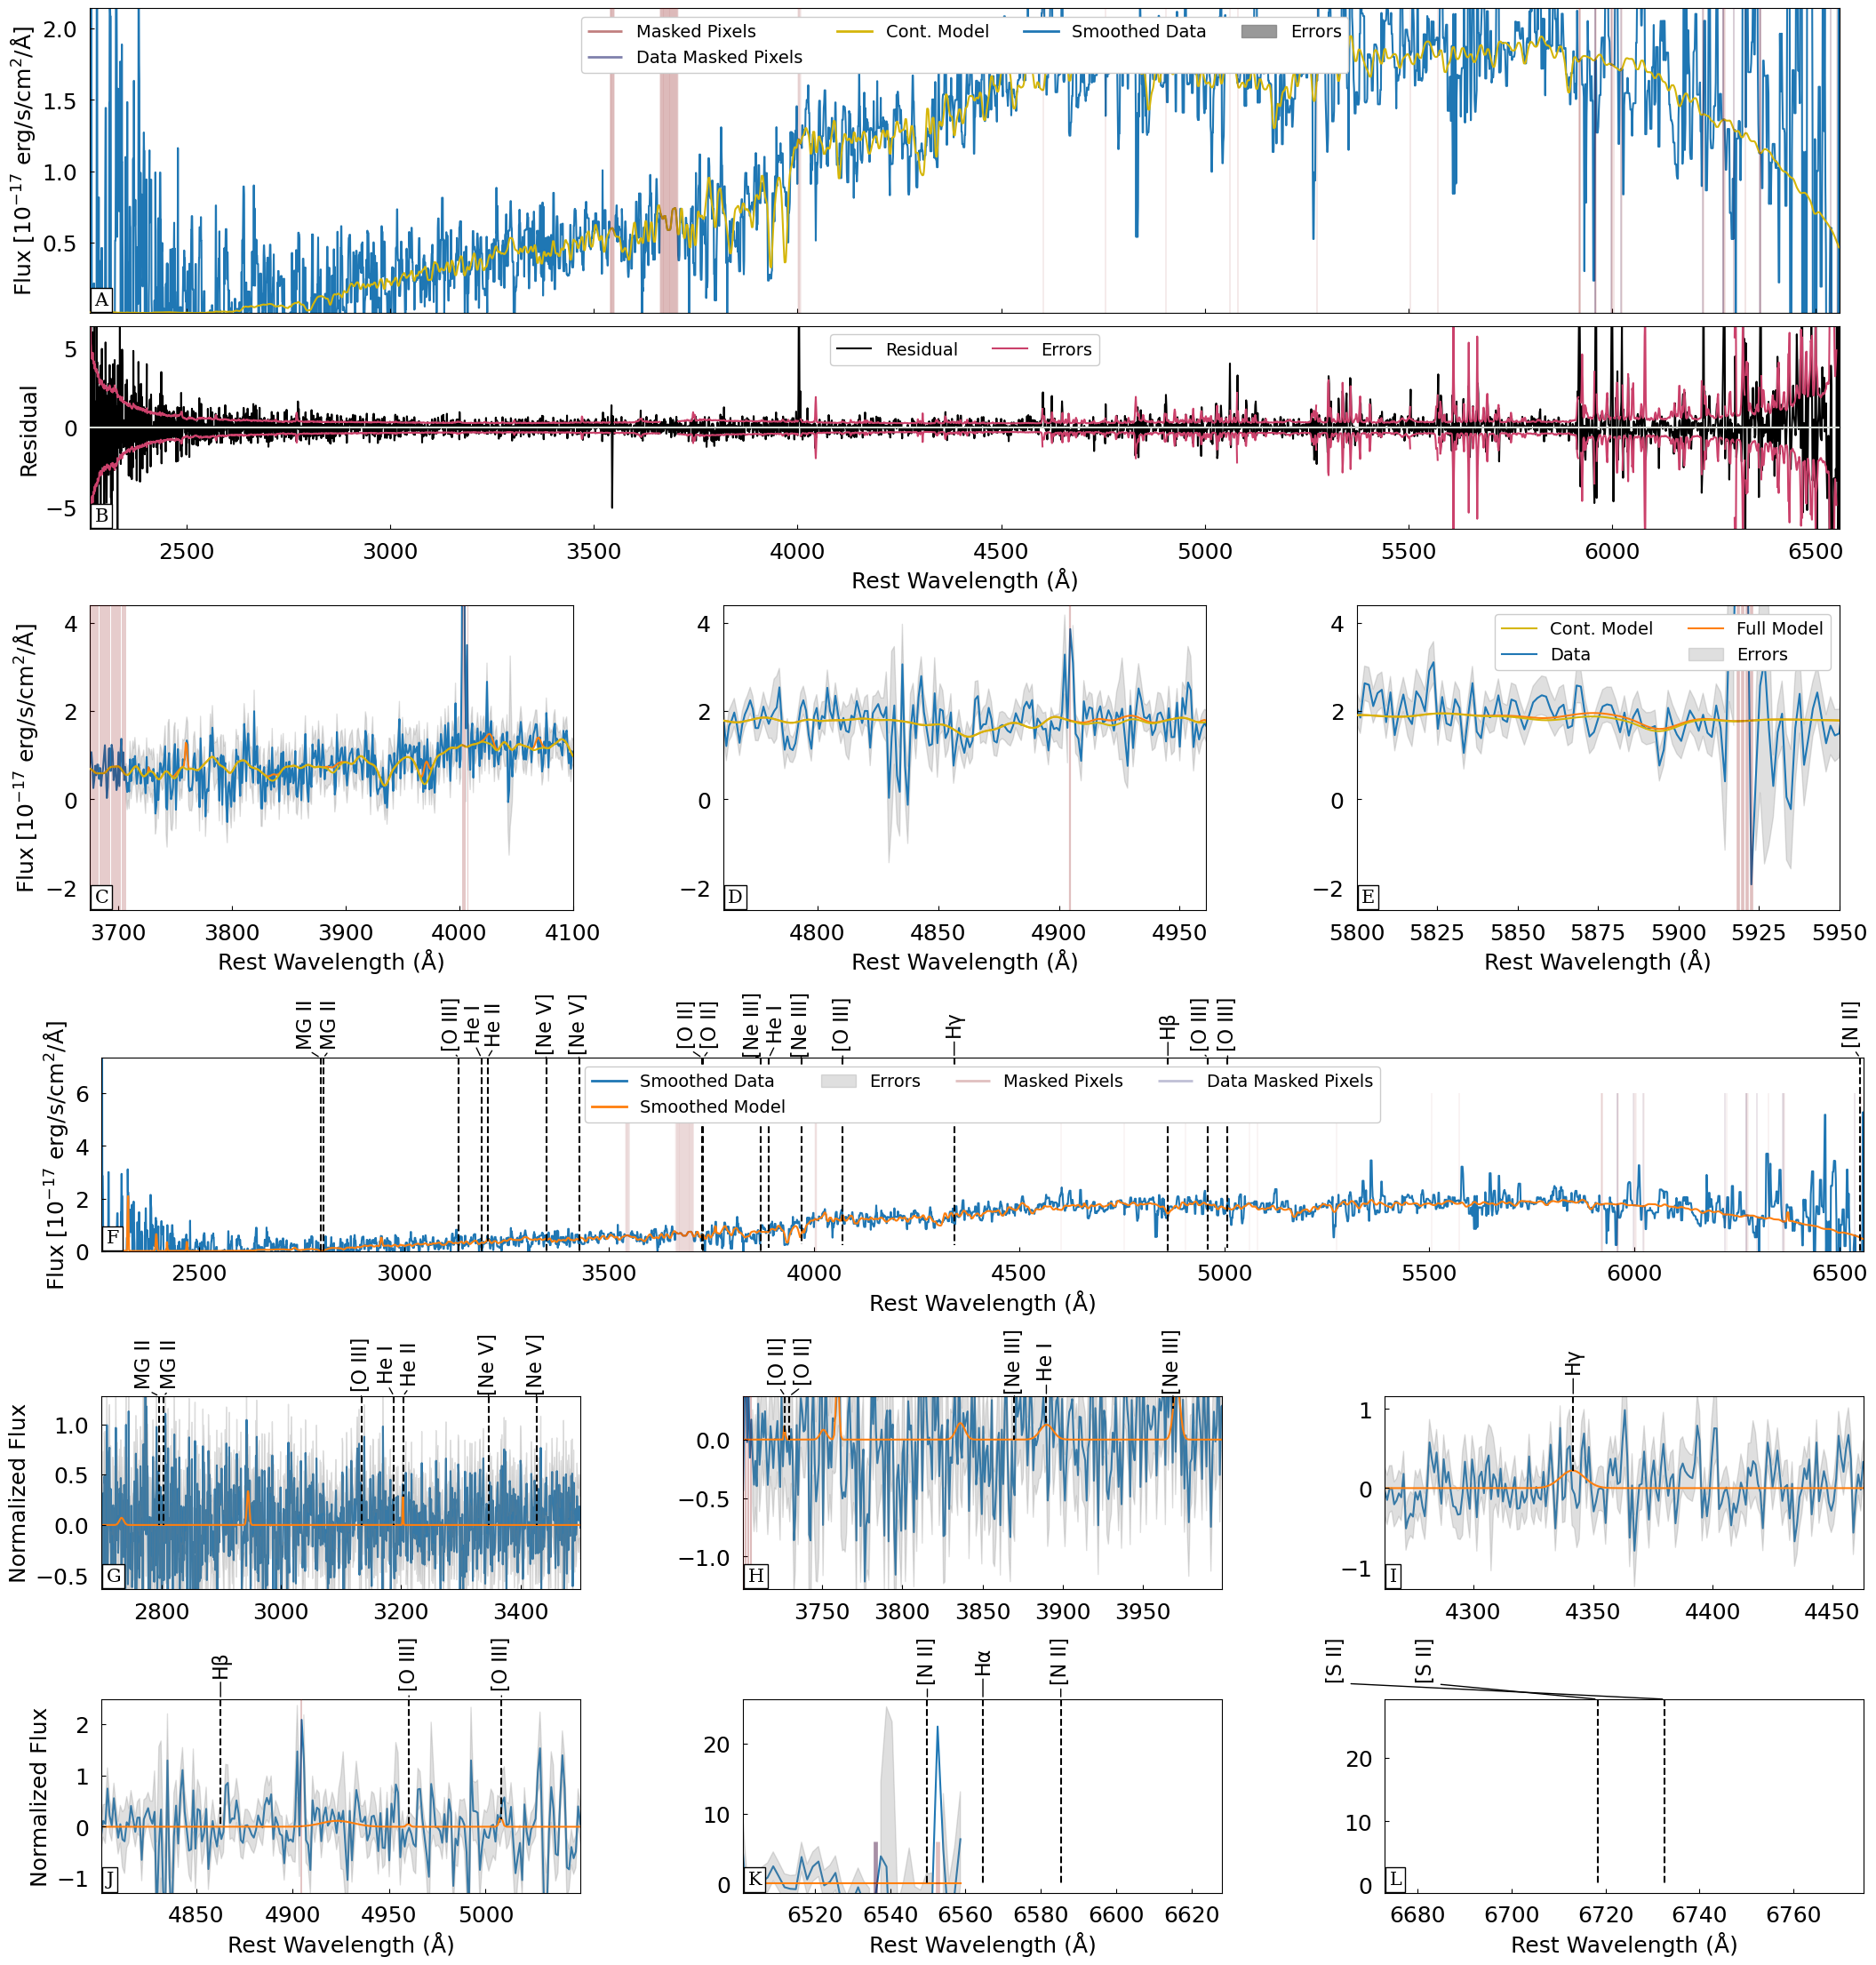

In [7]:
fig = plt.figure(layout='constrained', figsize=(21, 22))
subfigs = fig.subfigures(2, 1, hspace=0.01)


#Continuum Plots
axes_cont = subfigs[0].subplot_mosaic("AAA;BBB;CDE",height_ratios=np.array([3,2,3]))
#subfigs[0].tight_layout(pad=2.5,h_pad=0)
subfigs[0].subplots_adjust(hspace=0.15,bottom = 0.1)
legendfont = 14
#-------------------------------------------------------------------------------------------------------------------
if show_masked:
    axes_cont["A"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.5,lw=mask_lw_cont_a,zorder=50,label='Masked Pixels')
    axes_cont["C"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_cont_c,zorder=50)
    axes_cont["D"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_cont_d,zorder=50)
    axes_cont["E"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_cont_e,zorder=50)

    if show_data_mask:
        axes_cont["A"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.5,lw=data_mask_lw_cont_a,zorder=50,label='Data Masked Pixels')
        axes_cont["C"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_cont_c,zorder=50)
        axes_cont["D"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_cont_d,zorder=50)
        axes_cont["E"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_cont_e,zorder=50)

#------------------------------------------------------------------------------------------------------------------
axes_cont["A"].plot(restwave, smoothed_el_continuum, label='Cont. Model',color=elcont_c,zorder=5)
autoscale(axes_cont["A"], 'y', margin=0.1,std=data_std,stdmult=fstd,avg=data_avg,fit_type=2)
axes_cont["A"].plot(restwave, smoothed_data, label='Smoothed Data',color=data_c,zorder=0)
axes_cont["A"].fill_between([],  [],[],color = err_c, alpha = 0.8,label = 'Errors',zorder=30)
axes_cont["A"].margins(x=0)
axes_cont["A"].set_xticklabels([])
axes_cont["A"].set_ylabel('Flux [$10^{-17}$ erg/s/cm$^{2}$/Å]')
axes_cont["A"].set_ylim(0.01)
#-------------------------------------------------------------------------------------------------------------------
axes_cont["B"].plot(restwave, resid, label='Residual',alpha = 1.0,color=resid_c)
autoscale(axes_cont["B"], 'y', margin=0.0,std=data_std,stdmult=5,avg=0,fit_type=1)
axes_cont["B"].hlines(0,restwave[0],restwave[-1],color=zeroline_c,zorder=100)
axes_cont["B"].plot(restwave, errors,color = "xkcd:dark pink", ls = '-', alpha = 1.0,label = 'Errors')
axes_cont["B"].plot(restwave, -errors,color = "xkcd:dark pink", ls = '-', alpha = 1.0)
axes_cont["B"].set_xlabel('Rest Wavelength (Å)')
axes_cont["B"].set_ylabel('Residual')
axes_cont["B"].margins(x=0)
#-------------------------------------------------------------------------------------------------------------------
axes_cont["C"].plot(restwave, el_continuum, label='Cont. Model',color=elcont_c,zorder=10)
if np.nanmax(restwave) > cont_c_xlim[0] and np.nanmin (restwave) < cont_c_xlim[1]:
    autoscale(axes_cont["C"], 'y', margin=0.1,std=data_std,stdmult=5,avg=data_avg,fit_type=3)    
axes_cont["C"].plot(restwave, data_flux, label='Data',color=data_c,zorder = 1)
axes_cont["C"].plot(restwave, model_flux, label='Model',color=model_c,zorder=5)
axes_cont["C"].set_xlim(cont_c_xlim)
axes_cont["C"].fill_between(restwave,  data_flux + errors,data_flux - errors,color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_cont["C"].set_xlabel('Rest Wavelength (Å)')
axes_cont["C"].set_ylabel('Flux [$10^{-17}$ erg/s/cm$^{2}$/Å]')
#-------------------------------------------------------------------------------------------------------------------
axes_cont["D"].plot(restwave, el_continuum, label='Cont. Model',color=elcont_c,zorder=10)
if np.nanmax(restwave) > cont_d_xlim[0] and np.nanmin (restwave) < cont_d_xlim[1]:
    autoscale(axes_cont["D"], 'y', margin=0.1,std=data_std,stdmult=5,avg=data_avg,fit_type=3)
axes_cont["D"].plot(restwave, data_flux, label='Data',color=data_c,zorder=1)
axes_cont["D"].plot(restwave, model_flux, label='Full Model',color=model_c,zorder=5)
axes_cont["D"].set_xlim(cont_d_xlim)  
axes_cont["D"].fill_between(restwave,  data_flux + errors,data_flux - errors,color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_cont["D"].set_xlabel('Rest Wavelength (Å)')
#-------------------------------------------------------------------------------------------------------------------
axes_cont["E"].plot(restwave, el_continuum, label='Cont. Model',color=elcont_c,zorder=10)
if np.nanmax(restwave) > cont_e_xlim[0] and np.nanmin (restwave) < cont_e_xlim[1]:
    autoscale(axes_cont["E"], 'y', margin=0.1,std=data_std,stdmult=5,avg=data_avg,fit_type=3)
axes_cont["E"].plot(restwave, data_flux, label='Data',color=data_c,zorder=1)
axes_cont["E"].plot(restwave, model_flux, label='Full Model',color=model_c,zorder=5)
axes_cont["E"].set_xlim(cont_e_xlim)  
axes_cont["E"].fill_between(restwave,  data_flux + errors,data_flux - errors,color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_cont["E"].set_xlabel('Rest Wavelength (Å)')
#-------------------------------------------------------------------------------------------------------------------
legend_continuum = axes_cont["A"].legend(fontsize = legendfont,ncol=4,loc='upper center')
legend_continuum.get_frame().set_alpha(1.0)
legend_continuum.set_zorder(100)

legend_cutout = axes_cont["E"].legend(fontsize = legendfont,ncol=2,loc=1)
legend_cutout.get_frame().set_alpha(1.0)
legend_cutout.set_zorder(100)

legend_cutout = axes_cont["B"].legend(fontsize = legendfont,ncol=3,loc='upper center')
legend_cutout.get_frame().set_alpha(1.0)
legend_cutout.set_zorder(100)
for line in legend_continuum.get_lines():
    line.set_linewidth(2.0)
#-------------------------------------------------------------------------------------------------------------------

linelabels = ['','','','','']
for i, (label, ax) in enumerate(axes_cont.items()):
    # Use Axes.annotate to put the label
    # - at the top left corner (axes_cont fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes_cont.
    ax.annotate(
        label+''+linelabels[i],
        xy=(0, 0), xycoords='axes fraction',
        xytext=(+0.25, +0.25), textcoords='offset fontsize',
        fontsize='small', verticalalignment='bottom',horizontalalignment='left', fontfamily='serif',backgroundcolor='w',
        bbox=dict(facecolor='white', edgecolor='black', pad=3.0,alpha=1.0),zorder=100)

gap_multi = 0.1
posa = axes_cont["A"].get_position()  # Get the original position
posb = axes_cont["B"].get_position()

gap12 = posb.y1 - posa.y0     # Calculate the gap between the subplots
#axes_cont["B"].set_position([posa.x0, posa.y0+ gap12*gap_multi -  posb.height, posa.width, posb.height])

#-------------------------------------------------------------------------------------------------------------------
if custom_limits:
    print('Using Custom Limits')
    axes_cont["C"].set_ylim(cont_c_ylim)  
    axes_cont["D"].set_ylim(cont_d_ylim)  
    axes_cont["E"].set_ylim(cont_e_ylim) 
#-------------------------------------------------------------------------------------------------------------------


#Emission Plots
plotemlines = True
axes_eml = subfigs[1].subplot_mosaic("AAA;BCD;EFG")

axes_eml["A"].plot(restwave, smoothed_data, label='Smoothed Data',c=data_c,zorder = 0)
axes_eml["A"].plot(restwave, smoothed_model, label='Smoothed Model',c=model_c,zorder = 1)
autoscale(axes_eml["A"], 'y', margin=0.1,std=data_std,stdmult=fstd,avg=data_avg,fit_type=2)
axes_eml["A"].fill_between([],  [],[],color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_eml["A"].margins(x=0)
axes_eml["A"].set_xlabel('Rest Wavelength (Å)')
axes_eml["A"].set_ylabel('Flux [$10^{-17}$ erg/s/cm$^{2}$/Å]')
axes_eml["A"].set_ylim(0)
#-------------------------------------------------------------------------------------------------------------------
axes_eml["B"].plot(restwave, data_el, label='Data',c=data_c,zorder = 0)
axes_eml["B"].plot(restwave, eml_flux, label='Model',c=model_c,zorder = 1)
axes_eml["B"].set_xlim(eml_b_xlim)
if np.nanmax(restwave) > eml_b_xlim[0] and np.nanmin (restwave) < eml_b_xlim[1]:
    autoscale(axes_eml["B"], 'y', margin=0.1,std=data_std,stdmult=5,avg=data_avg,fit_type=1)
axes_eml["B"].set_ylim(-data_std/2,data_std)
axes_eml["B"].fill_between(restwave,  data_el + errors,data_el - errors,color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_eml["B"].set_ylabel('Normalized Flux')
#-------------------------------------------------------------------------------------------------------------------
axes_eml["C"].plot(restwave, data_el, label='Data',c=data_c,zorder = 0)
axes_eml["C"].plot(restwave, eml_flux, label='Model',c=model_c,zorder = 1)
axes_eml["C"].set_xlim(eml_c_xlim)
if np.nanmax(restwave) > eml_c_xlim[0] and np.nanmin (restwave) < eml_c_xlim[1]:
    autoscale(axes_eml["C"], 'y', margin=0.1,std=data_std,stdmult=5,avg=data_avg,fit_type=1)
axes_eml["C"].fill_between(restwave,  data_el + errors,data_el - errors,color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_eml["C"].set_ylim(-data_std)
#-------------------------------------------------------------------------------------------------------------------
axes_eml["D"].plot(restwave, eml_flux, label='Model',c=model_c,zorder = 1)
axes_eml["D"].plot(restwave, data_el, label='Data',c=data_c,zorder = 0)
axes_eml["D"].set_xlim([4263,4463])
if np.nanmax(restwave) > eml_d_xlim[0] and np.nanmin (restwave) < eml_d_xlim[1]:
    autoscale(axes_eml["D"], 'y', margin=0.1,std=data_std,stdmult=5,avg=data_avg,fit_type=1)
axes_eml["D"].fill_between(restwave,  data_el + errors,data_el - errors,color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_eml["D"].set_ylim(-data_std)
#-------------------------------------------------------------------------------------------------------------------
axes_eml["E"].plot(restwave, eml_flux, label='Model',c=model_c,zorder = 1)
axes_eml["E"].plot(restwave, data_el, label='Data',c=data_c,zorder = 0)
axes_eml["E"].set_xlim(eml_e_xlim)
if np.nanmax(restwave) > eml_e_xlim[0] and np.nanmin (restwave) < eml_e_xlim[1]:
    autoscale(axes_eml["E"], 'y', margin=0.1,std=data_std,stdmult=5,avg=data_avg,fit_type=1)
axes_eml["E"].fill_between(restwave,  data_el + errors,data_el - errors,color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_eml["E"].set_ylim(-data_std)
axes_eml["E"].set_xlabel('Rest Wavelength (Å)')
axes_eml["E"].set_ylabel('Normalized Flux')
#-------------------------------------------------------------------------------------------------------------------
axes_eml["F"].plot(restwave, eml_flux, label='Model',c=model_c,zorder = 1)
axes_eml["F"].plot(restwave, data_el, label='Data',c=data_c,zorder = 0)
axes_eml["F"].set_xlim(eml_f_xlim)
if np.nanmax(restwave) > eml_f_xlim[0] and np.nanmin (restwave) < eml_f_xlim[1]:
    autoscale(axes_eml["F"], 'y', margin=0.1,std=data_std,stdmult=5,avg=data_avg,fit_type=1)
axes_eml["F"].fill_between(restwave,  data_el + errors,data_el - errors,color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_eml["F"].set_ylim(-data_std)    
axes_eml["F"].set_xlabel('Rest Wavelength (Å)')
#-------------------------------------------------------------------------------------------------------------------
axes_eml["G"].plot(restwave, eml_flux, label='Model',c=model_c,zorder = 1)
axes_eml["G"].plot(restwave, data_el, label='Data',c=data_c,zorder = 0)
axes_eml["G"].set_xlim(eml_g_xlim)
if np.nanmax(restwave) > eml_g_xlim[0] and np.nanmin (restwave) < eml_g_xlim[1]:
    autoscale(axes_eml["G"], 'y', margin=0.1,std=data_std,stdmult=5,avg=data_avg,fit_type=1)
axes_eml["G"].fill_between(restwave,  data_el + errors,data_el - errors,color = err_c, alpha = 0.25,label = 'Errors',zorder=0)
axes_eml["G"].set_ylim(-data_std)
axes_eml["G"].set_xlabel('Rest Wavelength (Å)')
#-------------------------------------------------------------------------------------------------------------------
if show_masked:
    axes_eml["A"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_eml_a,zorder=50,label='Masked Pixels')
    axes_eml["B"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_eml_b,zorder=50)
    axes_eml["C"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_eml_c,zorder=50)
    axes_eml["D"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_eml_d,zorder=50)
    axes_eml["E"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_eml_e,zorder=50)
    axes_eml["F"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_eml_f,zorder=50)
    axes_eml["G"].vlines(mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=mask_c,alpha=0.25,lw=mask_lw_eml_g,zorder=50)

    if show_data_mask:
        axes_eml["A"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_eml_a,zorder=50,label='Data Masked Pixels')
        axes_eml["B"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_eml_b,zorder=50)
        axes_eml["C"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_eml_c,zorder=50)
        axes_eml["D"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_eml_d,zorder=50)
        axes_eml["E"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_eml_e,zorder=50)
        axes_eml["F"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_eml_f,zorder=50)
        axes_eml["G"].vlines(data_mask_lines,np.min(resid)-data_std,np.max(model_flux)+data_std,colors=data_mask_c,alpha=0.25,lw=data_mask_lw_eml_g,zorder=50)
#-------------------------------------------------------------------------------------------------------------------
if custom_limits:
    axes_eml["A"].set_ylim(eml_a_ylim)
    axes_eml["B"].set_ylim(eml_b_ylim)  
    axes_eml["C"].set_ylim(eml_c_ylim)  
    axes_eml["D"].set_ylim(eml_d_ylim)  
    axes_eml["E"].set_ylim(eml_e_ylim)  
    axes_eml["F"].set_ylim(eml_f_ylim)  
    axes_eml["G"].set_ylim(eml_g_ylim)  


#-------------------------------------------------------------------------------------------------------------------
legend_eml = axes_eml["A"].legend(fontsize = legendfont,ncol=4,loc='upper center')
legend_eml.get_frame().set_alpha(1.0)
legend_eml.set_zorder(100)
for line in legend_eml.get_lines():
    line.set_linewidth(2.0)
#-------------------------------------------------------------------------------------------------------------------
line_label1 = ['[O II]','[O II]','[Ne III]','He I','[Ne III]','Hγ','Hβ','[O III]','[O III]',
               '[N II]','Hα','[N II]','[S II]','[S II]','MG II','MG II','[O III]',
               'He I','He II','[Ne V]','[Ne V]','[O III]']
line_wave_list = [3727.092,3729.875,3869.86,3889.749,3968.59,4341.6837,4862.6830,4960.295,5008.240,
             6549.86,6564.608,6585.27,6718.295,6732.674,2796.3501,2803.5311,3134.2,     
             3188.67,3204.019,3346.783,3426.864,4069.75]
line_wave = (np.array(line_wave_list)).tolist()
label1_size = (np.ones_like(line_label1,dtype='float') *16.0).tolist()


if plotemlines:
    lineid_plot.plot_line_ids(restwave, eml_flux, (np.array(line_wave_list) ).tolist(), line_label1, label1_size, ax=axes_eml['A'],box_axes_space=0.02)
    lineid_plot.plot_line_ids(restwave, eml_flux, (np.array(line_wave_list) ).tolist(), line_label1, label1_size, ax=axes_eml['B'],box_axes_space=0.02)
    lineid_plot.plot_line_ids(restwave, eml_flux, (np.array(line_wave_list) ).tolist(), line_label1, label1_size, ax=axes_eml['C'],box_axes_space=0.02)
    lineid_plot.plot_line_ids(restwave, eml_flux, (np.array(line_wave_list) ).tolist(), line_label1, label1_size, ax=axes_eml['D'],box_axes_space=0.02)
    lineid_plot.plot_line_ids(restwave, eml_flux, (np.array(line_wave_list) ).tolist(), line_label1, label1_size, ax=axes_eml['E'],box_axes_space=0.02)
    lineid_plot.plot_line_ids(restwave, eml_flux, (np.array(line_wave_list) ).tolist(), line_label1, label1_size, ax=axes_eml['F'],box_axes_space=0.02)
    lineid_plot.plot_line_ids(restwave, eml_flux, (np.array(line_wave_list) ).tolist(), line_label1, label1_size, ax=axes_eml['G'],box_axes_space=0.02)
#-------------------------------------------------------------------------------------------------------------------
linelabels = ['F','G','H','I','J','K','L']
for i, (label, ax) in enumerate(axes_eml.items()):
    # Use Axes.annotate to put the label
    # - at the top left corner (axes_eml fraction (0, 1)),
    # - offset half-a-fontsize right and half-a-fontsize down
    #   (offset fontsize (+0.5, -0.5)),
    # i.e. just inside the axes_eml.
    ax.annotate(
        linelabels[i],
        xy=(0, 0), xycoords='axes fraction',
        xytext=(+0.25, +0.25), textcoords='offset fontsize',
        fontsize='small', verticalalignment='bottom',horizontalalignment='left', fontfamily='serif',backgroundcolor='w',
        bbox=dict(facecolor='white', edgecolor='black', pad=3.0,alpha=1.0),zorder=100)
#-------------------------------------------------------------------------------------------------------------------
gap_multi = 0.3
pos1 = axes_eml["B"].get_position()  # Get the original position
pos2 = axes_eml["E"].get_position()
gap = pos2.y0 - pos1.y1     # Calculate the gap between the subplots
#axes_eml["E"].set_position([pos2.x0, pos2.y1+ gap*gap_multi , pos2.width, pos2.height])
pos1 = axes_eml["C"].get_position()  # Get the original position
pos2 = axes_eml["F"].get_position()
gap = pos2.y0 - pos1.y1     # Calculate the gap between the subplots
pos1 = axes_eml["D"].get_position()  # Get the original position
pos2 = axes_eml["G"].get_position()
gap = pos2.y0 - pos1.y1     # Calculate the gap between the subplots
#-------------------------------------------------------------------------------------------------------------------

pyplot.savefig(str(Path().absolute())+tag+"_Combined_Plots.pdf", bbox_inches='tight')
pyplot.show()
pyplot.close()
